# Opening a Sushi Restaurant in the City of Porto

## Business Problem

The hypothetical business problem of this project is making a reasoned decision about where to open a sushi restaurant in the city of Porto in Portugal. The city of Porto is very trendy at the moment and is a touristic boom. On top of that there is a youthful culture regarding new experiences inherent to the city, which can lead to a great curiosity and openness towards experience non-portuguese food. 

The intent of this project is finding an optimal location area for the restaurant, tacking into account accessibility, concurrence and distance from hotels, schools and universities. 

To better understand the characteristics of the possible restaurant location I'm gonna subdivide the city of Porto into it's declared districts and then perform unsupervised machine learning to create clusters of districts based on the features described above. The description of the different Porto's areas can be helpful to guide the line of though of potential investors in this particular city.

## Data

Data needed:
1. List of districts of Porto
2. Coordinates (Latitude and Longitude) of the districts
3. List of several kinds of venues for each district
4. Most popular venues for each district

The list of districts of Porto was obtained exploring the city council website. 

The coordinates of each district were obtained with the help of Google Maps.

The list of different kinds of venues and the most popular venues for each district was obtained though a Foursquare API. 


In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

import seaborn as sns
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
import numpy as np

import random 

from sklearn.cluster import KMeans

### Dataframe for the districts of Porto

Based on the Porto's city council, the city has seven districts:
- Union of districts of Aldoar, Foz do Douro and Nevogilde
- Union of districts of Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória
- Union of the districts of Lordelo do Ouro and Massarelos
- Bonfim
- Campanhã
- Paranhos
- Ramalde

The districts are represented in the following figure:

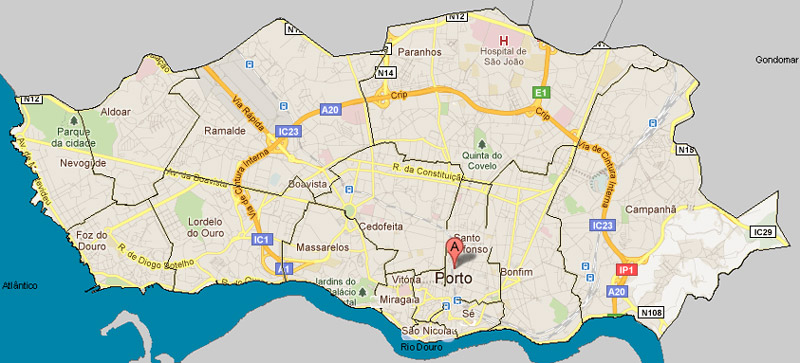

In [2]:
districts_dict = {'Districts':('Aldoar/Foz/Nevogilde','Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória',
                               'Lordelo/Massarelos','Bonfim','Campanhã','Paranhos','Ramalde')}

In [3]:
porto_districts = pd.DataFrame(districts_dict)

In [4]:
porto_districts

,Districts
0,Aldoar/Foz/Nevogilde
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória
2,Lordelo/Massarelos
3,Bonfim
4,Campanhã
5,Paranhos
6,Ramalde


Now with the help of Google Maps I'm gonna select the coordinates (latitude and longitude) and the radius of each district. It is important to specify a different radius for several districts since the total area of the districts clearly varies. 

In [5]:
latitude = [41.161290, 41.151764, 41.156975, 41.152498, 41.1601274, 41.174884, 41.177788]
longitude = [-8.667521, -8.613740, -8.639555, -8.588829, -8.568764, -8.607466, -8.638421]
radius = [1500, 1300, 1300, 1100, 1300, 1600, 1500]

In [6]:
porto_districts['Latitude']=latitude
porto_districts['Longitude']=longitude
porto_districts['Radius']=radius

In [7]:
porto_districts

,Districts,Latitude,Longitude,Radius
0,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300
2,Lordelo/Massarelos,41.156975,-8.639555,1300
3,Bonfim,41.152498,-8.588829,1100
4,Campanhã,41.160127,-8.568764,1300
5,Paranhos,41.174884,-8.607466,1600
6,Ramalde,41.177788,-8.638421,1500


Visualization of the districts

In [8]:
porto_map = folium.Map(location=[porto_districts['Latitude'].mean(), porto_districts['Longitude'].mean()], zoom_start=12) 

for lat, lng, district, radius in zip(porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Districts'], porto_districts['Radius']):
    folium.Circle(
        [lat, lng],
        radius=radius,
        color='blue',
        popup=district,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(porto_map)

# display map
porto_map

## Explore the districts of Porto

In order to decide about the optimal district to open a sushi restaurant I'm gonna explore the following type of venues for each district:
- Sushi Restaurants
- Hotels
- Schools and Universities
- Means of Transport
- Popular Venues

Foursquare API credentials:

In [9]:
CLIENT_ID = 'Q023MMPORTIE520GUD5YKPUXMDMK4XB3HAOO4YBZR4MCENVF' 
CLIENT_SECRET = 'WUW54PU4V4QEVLP443UHQM4EZNWPNPUA5SHAGECPODNAWDHH'
ACCESS_TOKEN = 'VV0VMWP4X2PMZDJDLKVDKPWVWVXKJHUI31LP1MO1HTHZBE3R' 
VERSION = '20210305' #specific date
LIMIT = 80
print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: Q023MMPORTIE520GUD5YKPUXMDMK4XB3HAOO4YBZR4MCENVF
CLIENT_SECRET:WUW54PU4V4QEVLP443UHQM4EZNWPNPUA5SHAGECPODNAWDHH


In [10]:
porto_districts.head()

,Districts,Latitude,Longitude,Radius
0,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300
2,Lordelo/Massarelos,41.156975,-8.639555,1300
3,Bonfim,41.152498,-8.588829,1100
4,Campanhã,41.160127,-8.568764,1300


Sort this dataframe by radius:

In [11]:
porto_districts = porto_districts.sort_values(by=['Radius'], ascending=True).reset_index(drop=True)
porto_districts.head()

,Districts,Latitude,Longitude,Radius
0,Bonfim,41.152498,-8.588829,1100
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300
2,Lordelo/Massarelos,41.156975,-8.639555,1300
3,Campanhã,41.160127,-8.568764,1300
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500


Function used to explore different kinds of venues:

In [13]:
''' Function to explore different kinds of venues
    input: string with the type of venue to explore
           dataframe with the description of the Porto's districts
           name of the venue to appear in the graphs and dataframes
    output: a dataframe with the venues listed and a dataframe with 
            the count of venues grouped by district'''

def explore_venue(venue_type, explore_df, venue_name):
    row = 0
    plt.rcParams.update({'font.size': 22})
    #List of the districts
    districts = []
    
    for district, latitude, longitude, radius in zip(porto_districts['Districts'], porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Radius']):
        search_query = venue_type
        #Radius of exploration
        radius = radius
        #Define the URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
        #Results of the query
        results = requests.get(url).json()
        #Assign relevant part of JSON to venues
        venues = results['response']['venues']
        df = pd.json_normalize(venues)
        #Number of venues per postal code coordinate
        number_venues = df.shape[0]
        #Create list with the districts associated with each venue
        for i in range(0,number_venues):
            districts.append(district)
            
        if row == 0:
            #Initialize the venues dataframe with the values of the first
            #postal code
            venues_df = df
        else:
            venues_df = venues_df.append(df)
            
        #Iterate the row 
        row = row + 1
        
    print('The number of venues of type {} is {}'.format(venue_type,venues_df.shape[0]))
    
    #Filter the venues dataframe
    filtered_columns =  ['name', 'categories', 'id', 'location.lat', 'location.lng']
    venues_df = venues_df.loc[:, filtered_columns]
    
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    #Filter the category for each row of the venues dataframe
    venues_df['categories'] = venues_df.apply(get_category_type, axis=1)

    #Clean column names by keeping only last term
    venues_df.columns = [column.split('.')[-1] for column in venues_df.columns]

    #Add the Postcodes and Boroughs columns
    venues_df['District'] = districts
    
    venues_df = venues_df.reset_index(drop=True)
    
    #Group the districts
    grouped_venues = venues_df.groupby('District').count().reset_index()[['District','name']].sort_values('name',ascending = False)
    grouped_venues = grouped_venues.rename(columns={'name':'# {}'.format(venue_name)})
    
    #Add the radius column to the grouped_venues dataframe
    radius_grouped_venues = []

    for district in grouped_venues['District']:
        radius = explore_df[explore_df['Districts']==district]['Radius'].values[0]
        radius_grouped_venues.append(radius)
    
    grouped_venues['Radius']=radius_grouped_venues
    grouped_venues = grouped_venues.sort_values(by='Radius')
    
    #Calculate the density of the number of venues since each district has a different radius 
    density = []
    for n_venues, radius in zip(grouped_venues.iloc[:,1], grouped_venues.iloc[:,2]):
        value = n_venues/radius
        density.append(value)
    
    grouped_venues['Density of {}'.format(venue_name)] = density
    
    #Plot the number of venues for each district
    plt.figure(figsize=(16,8))
    sns.barplot(x='# {}'.format(venue_name), y='District', data=grouped_venues)
    plt.title('Number of {} per District'.format(venue_name))
    plt.ylabel('District')
    plt.xlabel('Number of {}'.format(venue_name)) 
    plt.show()
    
    #Plot the density of venues for each district
    plt.figure(figsize=(16,8))
    sns.barplot(x='Density of {}'.format(venue_name), y='District', data=grouped_venues)
    plt.title('Density of {} per District'.format(venue_name))
    plt.ylabel('District')
    plt.xlabel('Density of {}'.format(venue_name)) 
    plt.show()
    
    return venues_df, grouped_venues
        

Since each district has a variable radius I decided to calculate the **density of venues** which is given by **number of venues/radius**.

### Sushi Restaurants

It is important to look for the concurrence in each district exploring the density and number of sushi restaurants.

Search for the number of sushi restaurants in each district using the explore_venue function:

The number of venues of type sushi is 54


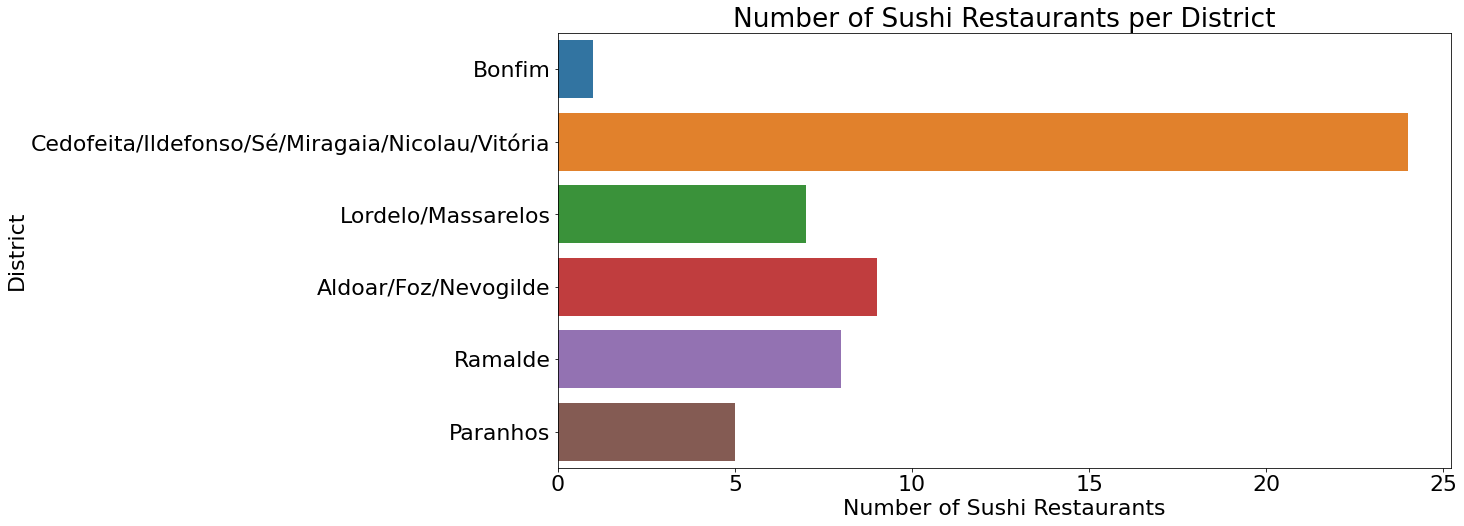

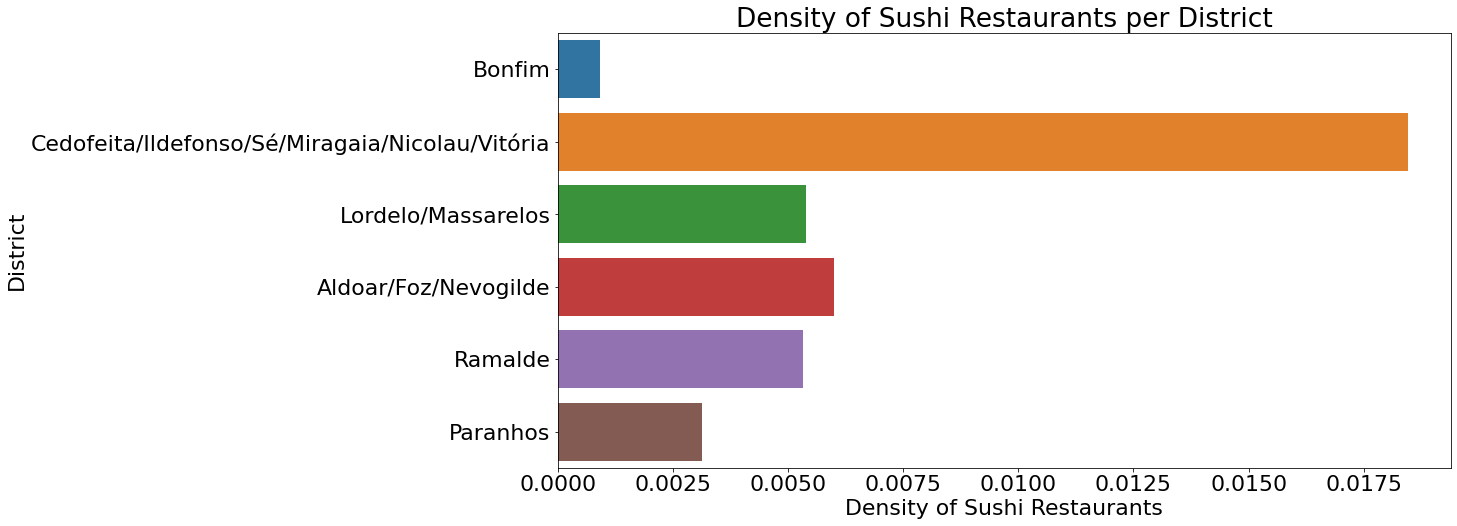

In [14]:
sushi_df, grouped_sushi = explore_venue('sushi', porto_districts,'Sushi Restaurants')

Clearly the district with higher number and density of Sushi Restaurants is the Union of Districts of Cedofeita/Ildefonso/Sé/Miragaia/Nicolou/Vitória. For now on I'm gonna refer to this district has city center, since this Union of districts contains the vast majority of the touristic attractions and activities of the city. 

In [15]:
sushi_df.head()

,name,categories,id,lat,lng,District
0,Sushi Store,Sushi Restaurant,5a0deaecc365885a82e1dbde,41.150145,-8.604800,Bonfim
1,Sushi & Douro,Sushi Restaurant,57b6f1df498ec3e4afc8a109,41.149781,-8.614819,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória
2,Mood & Sushi,Sushi Restaurant,5bbfb910cf72a0002cb25202,41.149690,-8.613024,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória
3,Sushi Rão,Sushi Restaurant,5ba4068f1f8ed6002c8fc555,41.155178,-8.610105,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória
4,Tori - Sushi House,Sushi Restaurant,5b1c2de9e1f0aa002c4ab1b3,41.155155,-8.610131,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória


In [16]:
sushi_df.shape

(54, 6)

The search resulted in 54 sushi restaurants.

In [17]:
grouped_sushi

,District,# Sushi Restaurants,Radius,Density of Sushi Restaurants
1,Bonfim,1,1100,0.000909
2,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,24,1300,0.018462
3,Lordelo/Massarelos,7,1300,0.005385
0,Aldoar/Foz/Nevogilde,9,1500,0.006000
5,Ramalde,8,1500,0.005333
4,Paranhos,5,1600,0.003125


In [18]:
porto_districts['# Sushi Restaurants'] = [1,24,7,0,9,8,5]
porto_districts['Density of Sushi']= [0.000909,0.018462,0.005385,0,0.006,0.005333,0.003125]

In [19]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi
0,Bonfim,41.152498,-8.588829,1100,1,0.000909
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385
3,Campanhã,41.160127,-8.568764,1300,0,0.000000
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000
5,Ramalde,41.177788,-8.638421,1500,8,0.005333
6,Paranhos,41.174884,-8.607466,1600,5,0.003125


### Hotels

Hotels are a critical venue to look for since people who are hosted in a hotel are likely to look for lunch or dinner in a restaurant outside the hotel. On top of that, higher density of hotels means higher density of tourists. 

Explore the number and density of hotels for each district:

The number of venues of type hotel is 141


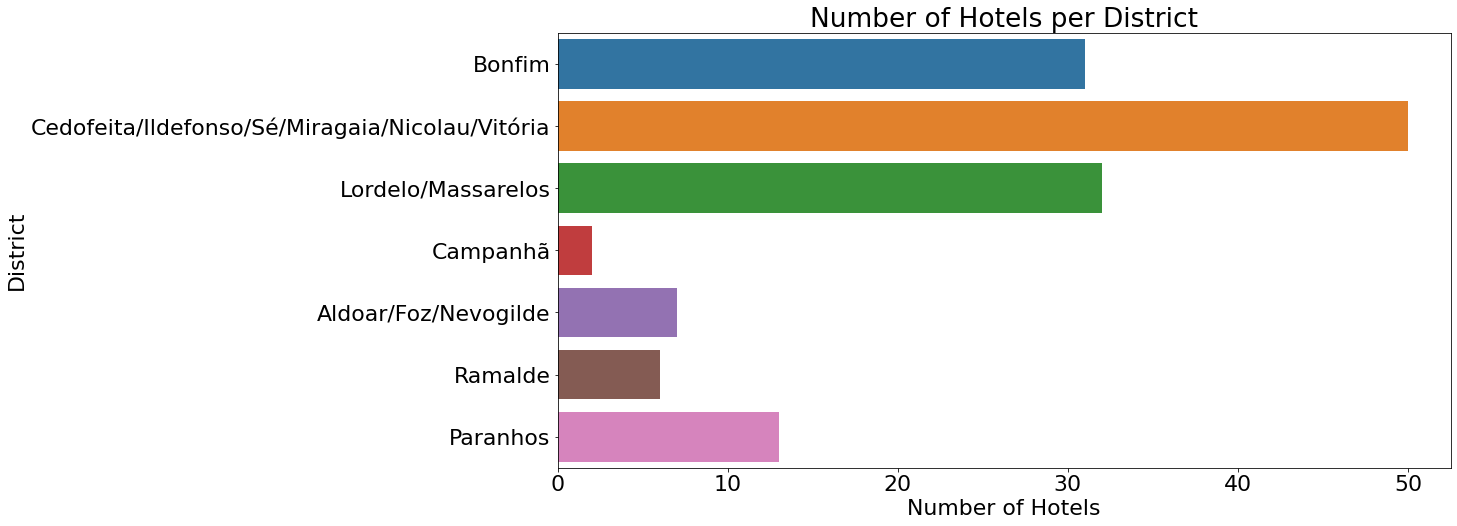

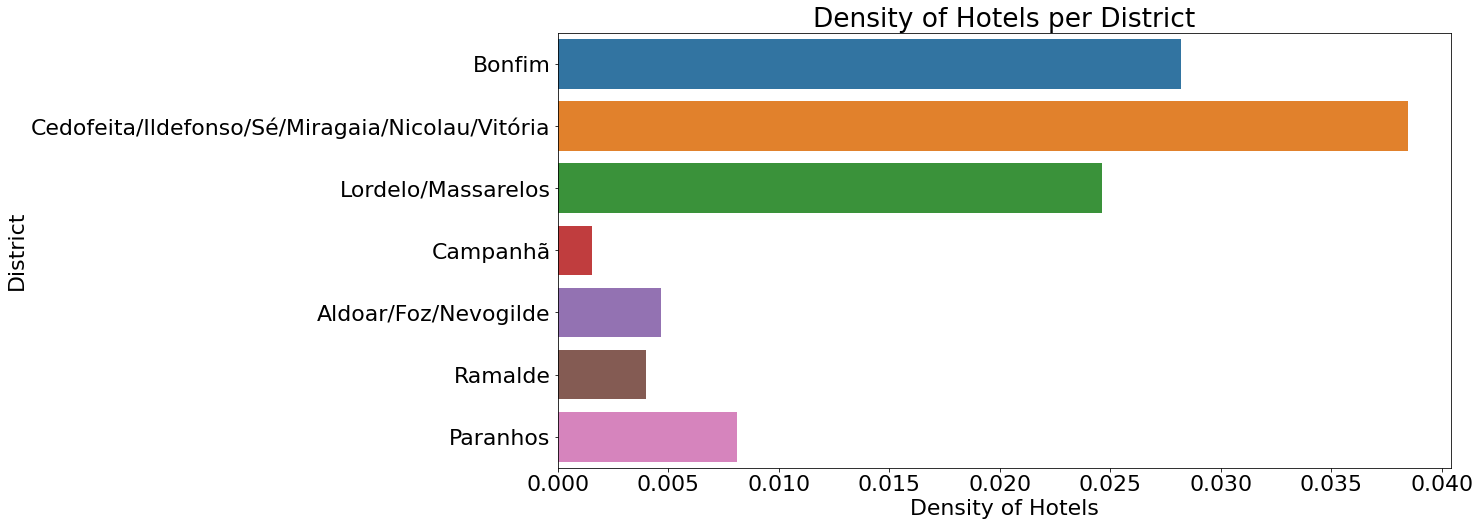

In [20]:
hotels_df, grouped_hotels = explore_venue('hotel', porto_districts,'Hotels')

The vast majority of Hotels are located in the city center has expected. After the city center, the two districts with higher hotel density are Bonfim and Lordelo/Massarelos, with a great gap in comparison to the other districts.

In [21]:
hotels_df.head()

,name,categories,id,lat,lng,District
0,Pensao Poveira Hotel Porto,Hotel,4e389934fa763bfcc366430f,41.148293,-8.586278,Bonfim
1,Hotel Vila Galé Porto,Hotel,4dd2534b6365cd4836e29244,41.150810,-8.598761,Bonfim
2,Hotel Menfis,Hotel,4e1c1052b61cb7bbd0d8029d,41.150983,-8.600637,Bonfim
3,Hotel Tryp Porto Centro,Hotel,4bcc5b39aeaaeee150ec3d6d,41.157151,-8.602191,Bonfim
4,Hotel S. José,Hotel,4d1aedff5acb721e37580ab2,41.149503,-8.604102,Bonfim


In [22]:
hotels_df.shape

(141, 6)

The search resulted in 141. hotels in the city of Porto.

In [23]:
grouped_hotels

,District,# Hotels,Radius,Density of Hotels
1,Bonfim,31,1100,0.028182
3,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,50,1300,0.038462
4,Lordelo/Massarelos,32,1300,0.024615
2,Campanhã,2,1300,0.001538
0,Aldoar/Foz/Nevogilde,7,1500,0.004667
6,Ramalde,6,1500,0.004000
5,Paranhos,13,1600,0.008125


In [24]:
porto_districts['# Hotels'] = grouped_hotels['# Hotels'].values
porto_districts['Density of Hotels'] = grouped_hotels['Density of Hotels'].values

In [25]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125


### Schools and Universities

In my opinion, schools and universities are good venues to look for since they can lead to higher affluence. Firstly, this venues can lead to group lunches, and sushi is a great option for this particular case. Secondly, students are usually open minded for new experiences, and foreign gastronomy is not an exception. On top of that, sushi is really trendy at the moment, and adolescents have a higher tendency to follow trends. 

Search for the number and density of schools and universities:

The number of venues of type escola universidade is 214


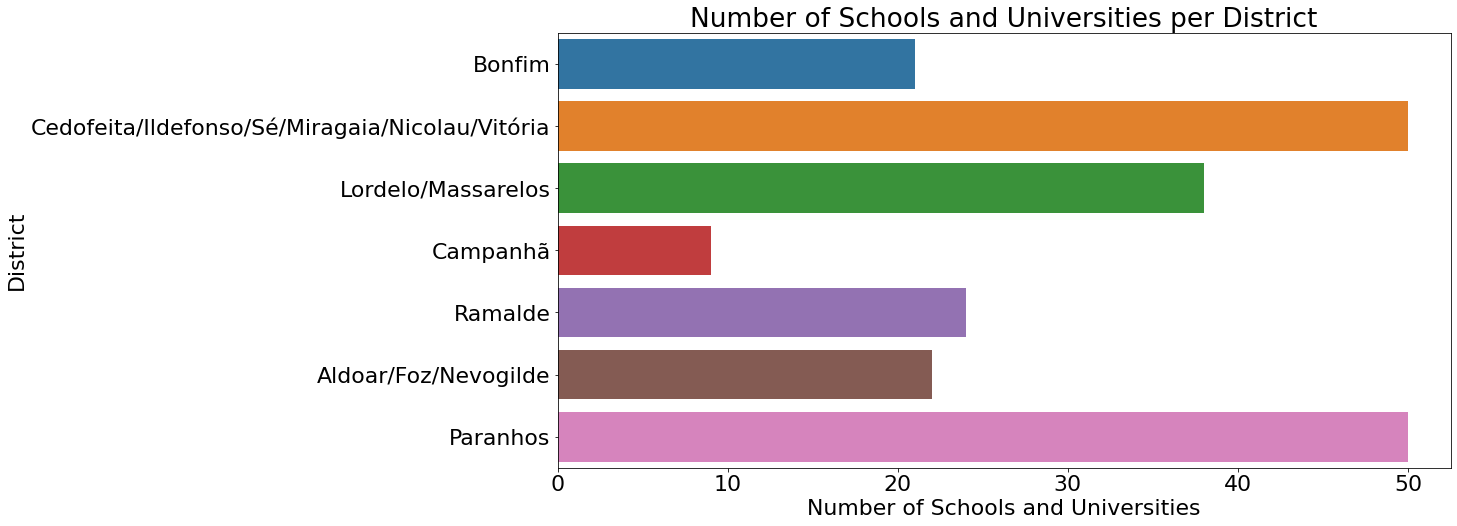

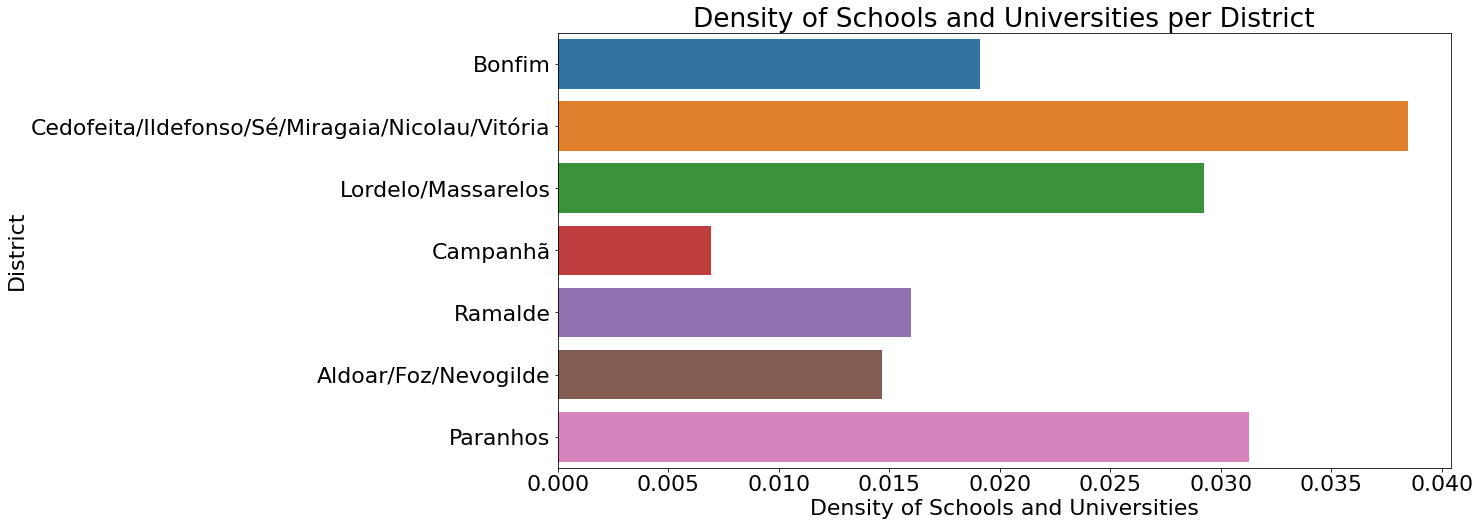

In [26]:
schools_df, grouped_schools = explore_venue('escola universidade', porto_districts,'Schools and Universities')

Once again the city center has the higher density of schools and universities, followed by Paranhos, which is a district with a lot of universities, and Lordelo/Massarelos. 

In [27]:
schools_df

,name,categories,id,lat,lng,District
0,Escola das Flores,Preschool,57d989facd108558dd45ee5c,41.156317,-8.590505,Bonfim
1,Escola de Condução de Campanhã,Automotive Shop,56ab6320498eee53924373b3,41.150257,-8.588739,Bonfim
2,Escola Profissional do Centro Juvenil de Campanhã,General College & University,4bb32716715eef3b45f885bb,41.150710,-8.583834,Bonfim
3,Escola Secundária Alexandre Herculano,School,504be17ee4b02e54391e9f45,41.148668,-8.594674,Bonfim
4,Escola Secundária Aurélia De Sousa,School,512fa2c2e4b00bf9b10a6837,41.158618,-8.599601,Bonfim
...,...,...,...,...,...,...
209,Núcleo Estudantil do IEEE da Universidade do P...,Student Center,54bfc12e498e35467334a859,41.178766,-8.595345,Paranhos
210,Universidade Sénior Contemporânea do porto,University,51d9e89f498e2622bd054aea,41.182154,-8.616306,Paranhos
211,DeROSE Method Antas - Escola Eduardo Cirilo,Adult Education Center,5cb079fa666116002cfa5658,41.164359,-8.599216,Paranhos
212,E-COPY da Universidade Lusiada do Porto,Paper / Office Supplies Store,4f55f9e7e4b09c08b91bb13f,41.183490,-8.590593,Paranhos


In [28]:
grouped_schools

,District,# Schools and Universities,Radius,Density of Schools and Universities
1,Bonfim,21,1100,0.019091
3,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,50,1300,0.038462
4,Lordelo/Massarelos,38,1300,0.029231
2,Campanhã,9,1300,0.006923
6,Ramalde,24,1500,0.016000
0,Aldoar/Foz/Nevogilde,22,1500,0.014667
5,Paranhos,50,1600,0.031250


In [29]:
porto_districts['# Schools&Universities'] = grouped_schools['# Schools and Universities'].values
porto_districts['Density of Schools&Universities'] = grouped_schools['Density of Schools and Universities'].values

In [30]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250


### Means of Transportation

Easy accessibility to the suchi restaurant location is vital to the success of the venue. I'm gonna explore the number and density of venues related to metros and buses. 

The number of venues of type metro bus is 96


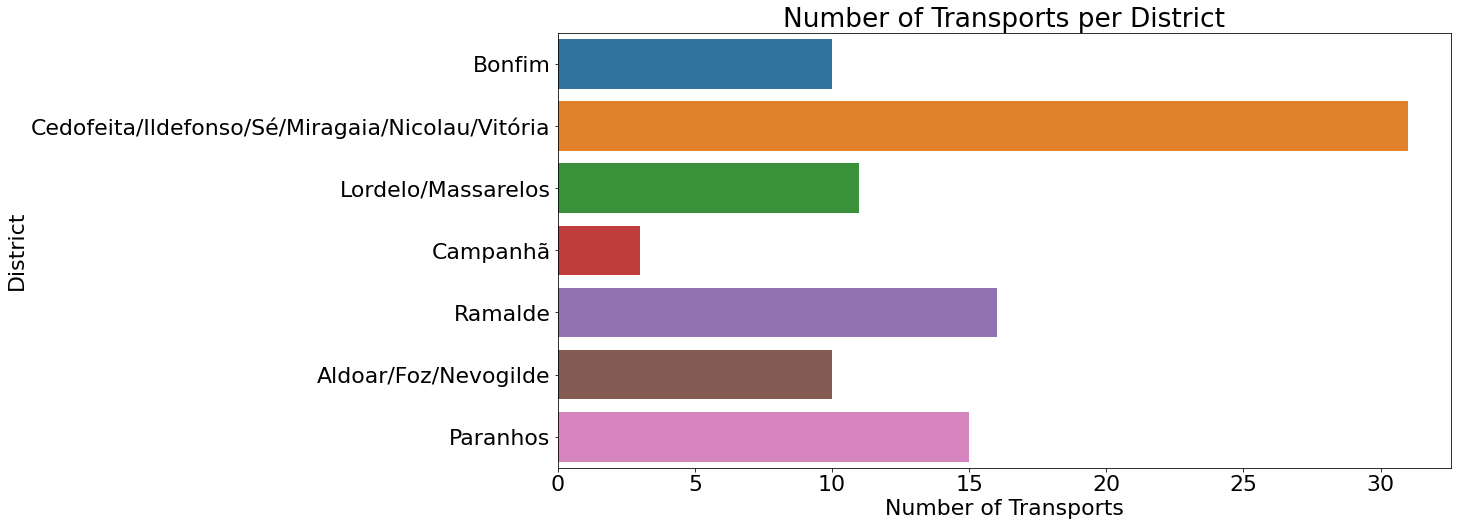

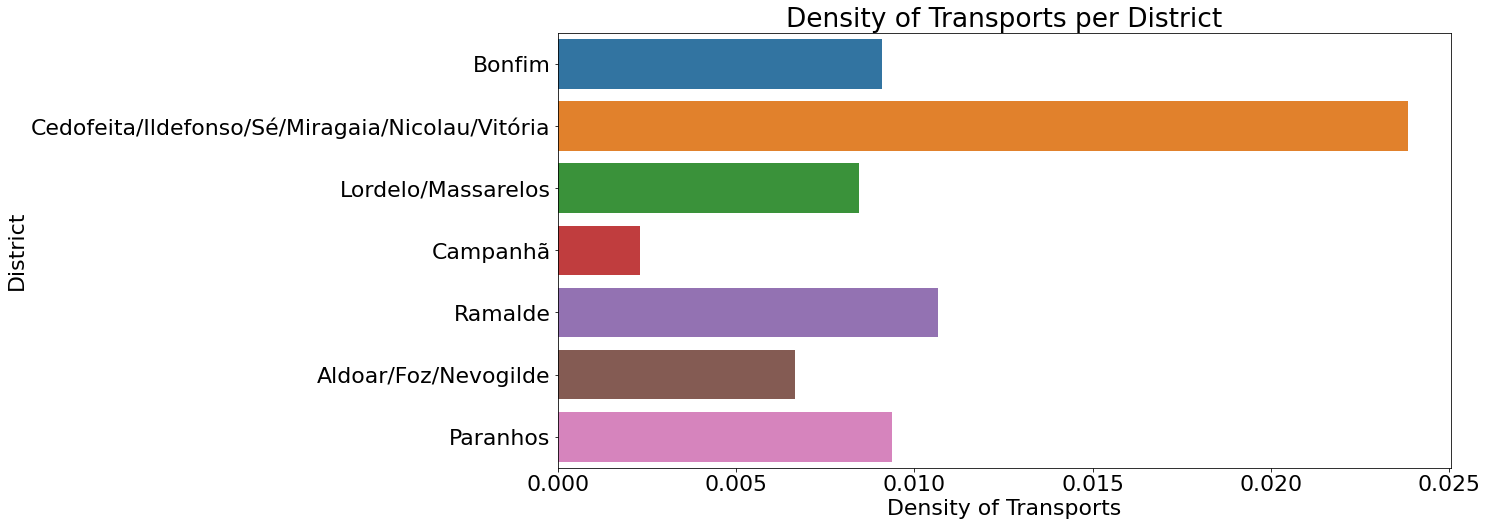

In [31]:
transports_df, grouped_transports = explore_venue('metro bus', porto_districts,'Transports')

As expected there is a huge gap regarding the means of transport between the city center and the surrounding districts.

In [32]:
transports_df

,name,categories,id,lat,lng,District
0,"Metro Campanhã [A,B,C,E,F]",Metro Station,4d48369b11618cfa051fd223,41.150438,-8.585587,Bonfim
1,"Metro, Sentido Ismai",Transportation Service,598e06de0a464d25e369c7ad,41.152146,-8.587867,Bonfim
2,"Metro Heroísmo [A,B,C,E,F]",Metro Station,4d9de210baae5481defffb64,41.146551,-8.592930,Bonfim
3,"Metro 24 de Agosto [A,B,C,E,F]",Metro Station,4c2c69a8b34ad13a3d3cebce,41.148956,-8.598372,Bonfim
4,"Metro Estádio do Dragão [A,B,E,F]",Metro Station,4c293801ce3fc92869736e88,41.160716,-8.582049,Bonfim
...,...,...,...,...,...,...
91,ZOME Business CEC,Real Estate Office,5b2d12c42db4a9002ca50951,41.180073,-8.620708,Paranhos
92,KW Business,Real Estate Office,52fcf744498e6578fa227b88,41.162155,-8.615147,Paranhos
93,Pastelaria Bússola Triunfo,Bakery,54b24f80498e7a32a014d5f6,41.164820,-8.600101,Paranhos
94,GoGlobal Business Experts,Office,57889c46498e4bcb1e8e2e97,41.178600,-8.622056,Paranhos


As we can see there are outputs of the search that have nothing to do with means of transport, like Bakeries and Hotels. So, to clean the output and to be sure about the precision of this search I'm gonna count the number of venues with station, metro, bus or transportation in its name or category. 

In [33]:
i = 1
for category in transports_df['categories']:
    
    if 'station' in category.lower() or 'metro' in category.lower() or 'bus' in category.lower() or 'transportation' in category.lower():
        i = i + 1
    

In [34]:
print(i)

57


**There are only 57 entries out of the 96 that are clearly a transportation service**

In [35]:
i = 1
rows_to_drop = []
for row, category in enumerate(transports_df['categories']):
    if 'station' in category.lower() or 'metro' in category.lower() or 'bus' in category.lower() or 'transportation' in category.lower():
        i = i + 1
    else:
        rows_to_drop.append(row)

Let's drop all the rows that are not clearly related to transportation services.

In [36]:
transports_df = transports_df.drop(index = rows_to_drop)
transports_df.head()

,name,categories,id,lat,lng,District
0,"Metro Campanhã [A,B,C,E,F]",Metro Station,4d48369b11618cfa051fd223,41.150438,-8.585587,Bonfim
1,"Metro, Sentido Ismai",Transportation Service,598e06de0a464d25e369c7ad,41.152146,-8.587867,Bonfim
2,"Metro Heroísmo [A,B,C,E,F]",Metro Station,4d9de210baae5481defffb64,41.146551,-8.592930,Bonfim
3,"Metro 24 de Agosto [A,B,C,E,F]",Metro Station,4c2c69a8b34ad13a3d3cebce,41.148956,-8.598372,Bonfim
4,"Metro Estádio do Dragão [A,B,E,F]",Metro Station,4c293801ce3fc92869736e88,41.160716,-8.582049,Bonfim


In [37]:
grouped_transports

,District,# Transports,Radius,Density of Transports
1,Bonfim,10,1100,0.009091
3,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,31,1300,0.023846
4,Lordelo/Massarelos,11,1300,0.008462
2,Campanhã,3,1300,0.002308
6,Ramalde,16,1500,0.010667
0,Aldoar/Foz/Nevogilde,10,1500,0.006667
5,Paranhos,15,1600,0.009375


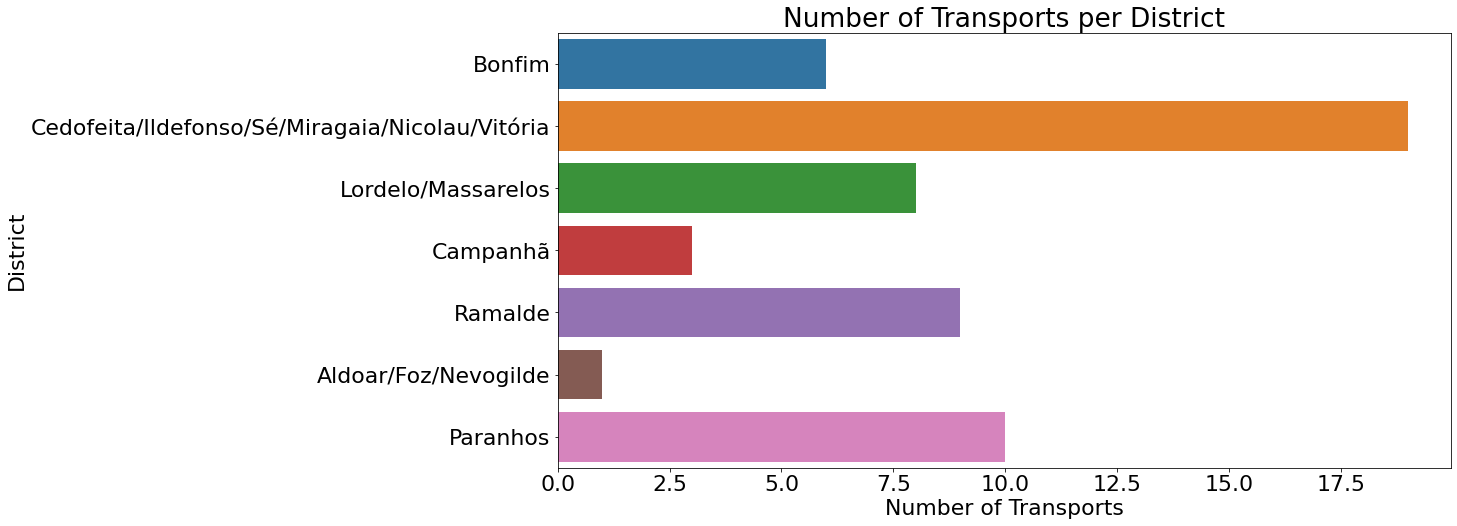

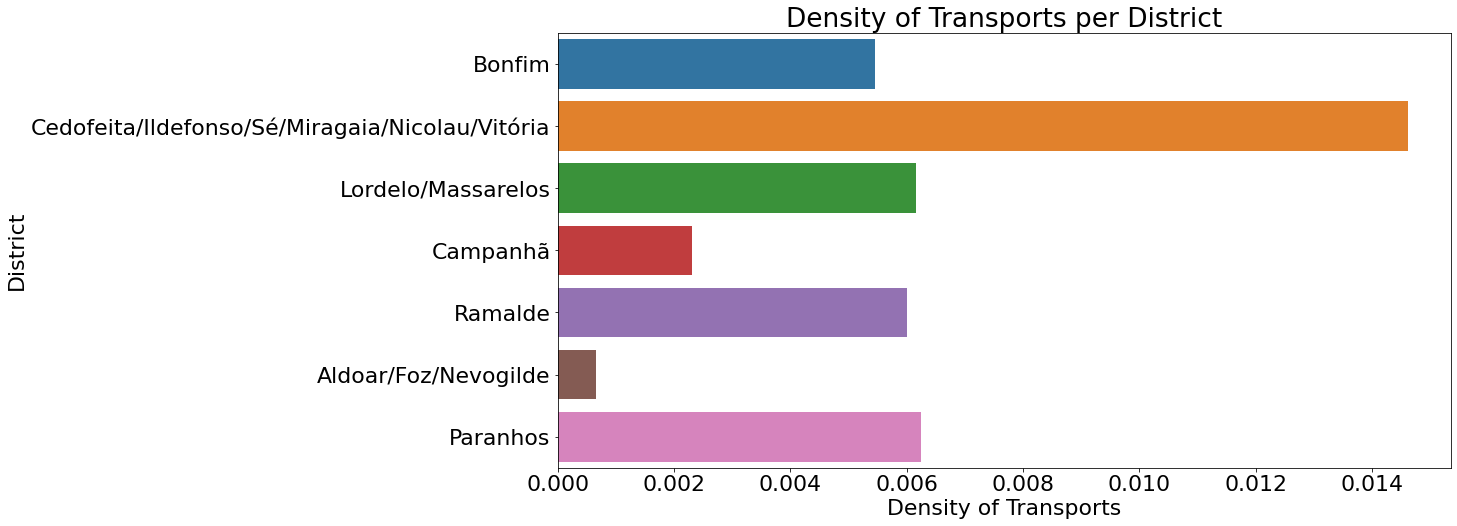

In [38]:
#Group the districts
grouped_transports = transports_df.groupby('District').count().reset_index()[['District','name']].sort_values('name',ascending = False)
grouped_transports = grouped_transports.rename(columns={'name':'# Transports'})
    
#Add the radius column to the grouped_venues dataframe
radius_grouped_venues = []

for district in grouped_transports['District']:
    radius = porto_districts[porto_districts['Districts']==district]['Radius'].values[0]
    radius_grouped_venues.append(radius)
    
grouped_transports['Radius']=radius_grouped_venues
grouped_transports = grouped_transports.sort_values(by='Radius')
    
#Calculate the density of the number of transports since each district has a different radius 
density = []
for n_venues, radius in zip(grouped_transports.iloc[:,1], grouped_transports.iloc[:,2]):
    value = n_venues/radius
    density.append(value)
    
grouped_transports['Density of transports'] = density

plt.rcParams.update({'font.size': 22})
#Plot the number of transports for each district
plt.figure(figsize=(16,8))
sns.barplot(x='# Transports', y='District', data=grouped_transports)
plt.title('Number of Transports per District')
plt.ylabel('District')
plt.xlabel('Number of Transports') 
plt.show()
    
#Plot the density of venues for each district
plt.figure(figsize=(16,8))
sns.barplot(x='Density of transports', y='District', data=grouped_transports)
plt.title('Density of Transports per District')
plt.ylabel('District')
plt.xlabel('Density of Transports') 
plt.show()
    

There is still a relative big gap between the city center and the rest of the districts.

In [39]:
grouped_transports

,District,# Transports,Radius,Density of transports
1,Bonfim,6,1100,0.005455
3,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,19,1300,0.014615
4,Lordelo/Massarelos,8,1300,0.006154
2,Campanhã,3,1300,0.002308
6,Ramalde,9,1500,0.006000
0,Aldoar/Foz/Nevogilde,1,1500,0.000667
5,Paranhos,10,1600,0.006250


In [40]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250


In [41]:
porto_districts['# Transports'] = grouped_transports['# Transports'].values
porto_districts['Density of Transports'] = grouped_transports['Density of transports'].values

In [42]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091,6,0.005455
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923,3,0.002308
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000,9,0.006000
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667,1,0.000667
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250,10,0.006250


### Popular venues of each district

In this section I'm gonna explore the popular spots of each district of the city. For this purpous I'm going to write a function that extracts and plots the most popular venues for each district in the city of Porto.

In [45]:
#Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [49]:
''' Function that gets and plots the most popular venues of a single district
    input - dataframe with the Porto's districts and the district
    output - dataframe with the most popular spots for each district and the count of 
             popular sushi venues'''

def popular_venues(porto_districts, district):
    
    sushi_names = []
    sushi_categories = []
    
    row = porto_districts[porto_districts['Districts']==district]
    latitude = row['Latitude'].values[0]
    longitude = row['Longitude'].values[0]
    radius = row['Radius'].values[0]
    #URL for the popular spots query
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    dataframe = pd.json_normalize(items) # flatten JSON
    #Filter columns
    filtered_columns = ['venue.name', 'venue.location.lat','venue.location.lng','venue.categories'] 
    dataframe_filtered = dataframe.loc[:, filtered_columns]
    #Filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
    #Clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
    
    plt.rcParams.update({'font.size': 14})
    #Plot the top 5 most popular venues categories for each district
    plt.figure(figsize=(10,5))
    sns.barplot(data=dataframe_filtered.categories.value_counts().to_frame().reset_index().iloc[0:5,:],
                    x='categories', y='index')
    plt.title('Top 5 Most Popular venues categories in the district {}'.format(district))
    plt.xlabel('Count')
    plt.ylabel('Venues')
    plt.show()
    
    #Search for popular sushi venues
    i = 0
    for category,name in zip(dataframe_filtered.categories, dataframe_filtered.name):
        if 'sushi' in category.lower() or 'japanese' in category.lower() or 'sushi' in name.lower() or 'japanese' in name.lower():
            i = i + 1
            
    print('Number of Popular Sushi Venues is {}'.format(i))
            
    
    return row, dataframe_filtered
        
        

        

#### Bonfim

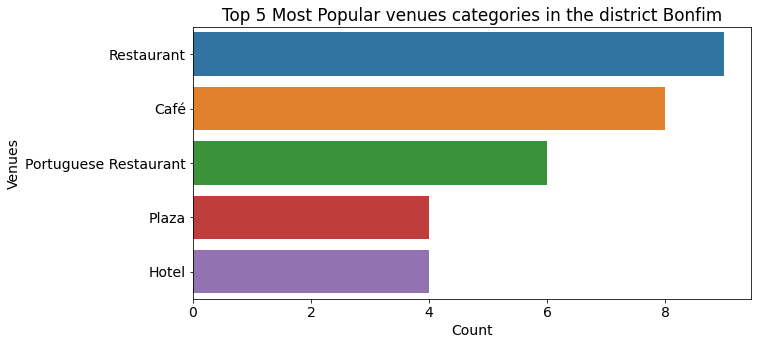

Number of Popular Sushi Venues is 0


In [50]:
bonfim, popular_venues_bonfim = popular_venues(porto_districts,'Bonfim')

In [51]:
bonfim

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091,6,0.005455


There is a clear trend in the district of Bonfim for restaurants. This can be a good indicator that this district is a good candidate for the sushi restaurant. However, the only sushi restaurant of this district is not trendy. Let's check the trendy restaurants.

In [52]:
popular_venues_bonfim[popular_venues_bonfim['categories']=='Restaurant']

,name,lat,lng,categories
0,Casa Aleixo,41.147363,-8.587401,Restaurant
4,Manuel Alves,41.156655,-8.594456,Restaurant
13,Nova Era,41.146940,-8.596478,Restaurant
14,Caetano,41.159999,-8.592492,Restaurant
17,Moment' Um,41.148095,-8.586227,Restaurant
40,Segredos de Cristal,41.149225,-8.586441,Restaurant
48,Restaurante Triunfante ll,41.150519,-8.598127,Restaurant
53,Barrigas,41.159174,-8.597875,Restaurant
55,Restaurante Monte Aventino,41.161506,-8.589576,Restaurant


#### Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória

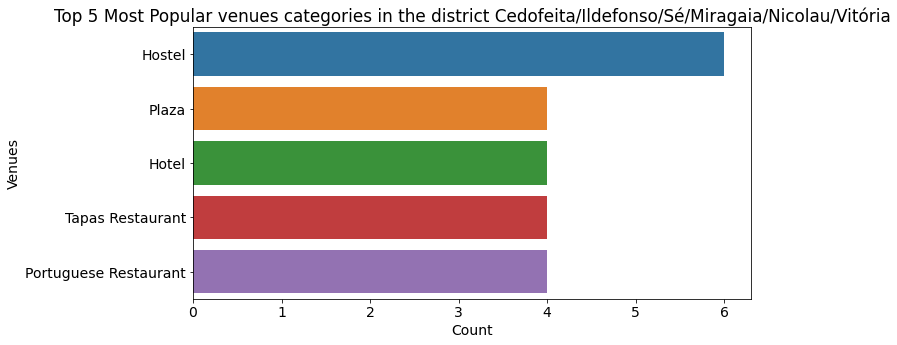

Number of Popular Sushi Venues is 3


In [53]:
cc, popular_venues_cc = popular_venues(porto_districts,'Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória')

In [54]:
cc

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.61374,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615


There is a clear trend for tourism related venues in the city center. Only 2 out of the 24 sushi restaurants in the city center are trendy at the moment.

#### Lordelo/Massarelos

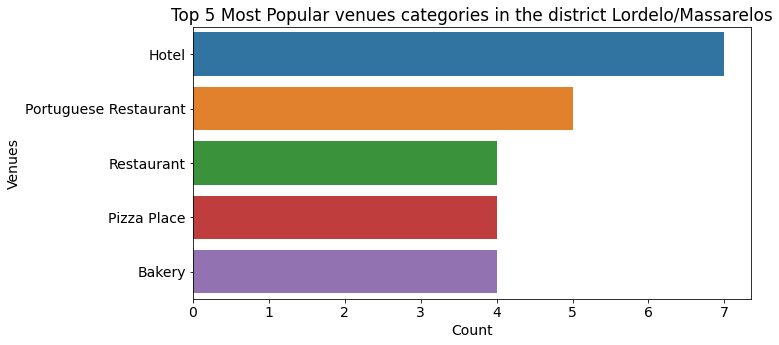

Number of Popular Sushi Venues is 1


In [55]:
lm, popular_venues_lm = popular_venues(porto_districts,'Lordelo/Massarelos')

In [56]:
lm

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154


There is a clear trend for hotels in the district of Lordelo/Massarelos. Only 1 out of 7 sushi restaurants in this district are popular.

#### Campanhã

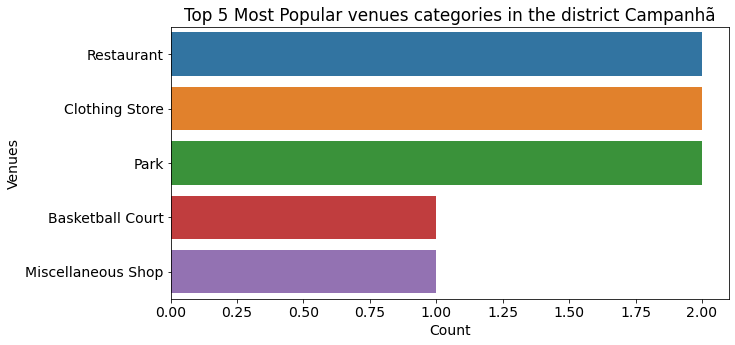

Number of Popular Sushi Venues is 0


In [57]:
cam, popular_venues_cam = popular_venues(porto_districts,'Campanhã')

In [58]:
cam

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
3,Campanhã,41.160127,-8.568764,1300,0,0.0,2,0.001538,9,0.006923,3,0.002308


There are no particularly trendy category in this district.

#### Aldoar/Foz/Nevogilde

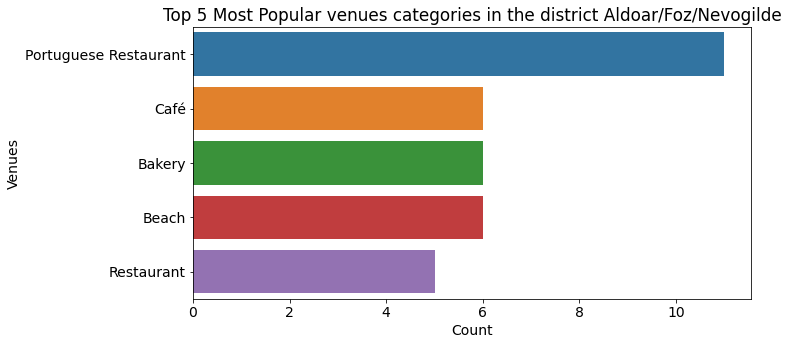

Number of Popular Sushi Venues is 8


In [59]:
afn, popular_venues_afn = popular_venues(porto_districts,'Aldoar/Foz/Nevogilde')

In [60]:
afn

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
4,Aldoar/Foz/Nevogilde,41.16129,-8.667521,1500,9,0.006,7,0.004667,24,0.016,9,0.006


Surprisingly, 8 out of 9 sushi restaurants in this district are trendy at the moment. This indicator alone can be significant to choose this district as the location of the restaurant.

Let's see this restaurants name.

In [61]:
sushi_names = []
for category, name in zip(popular_venues_afn.categories, popular_venues_afn.name):
        if 'sushi' in category.lower() or 'japanese' in category.lower() or 'sushi' in name.lower() or 'japanese' in name.lower():
            sushi_names.append(name)
            

In [62]:
sushi_names

['Kanpai Fusion Sushi',
 'Kayo',
 'Sushi & Douro',
 'Ichiban',
 'Wish Restaurant&Sushi',
 'Sushihana Sushi Bar',
 'Sushi-naka',
 'Ritual do Paladar']

In [63]:
rows = []
for row, name in enumerate(popular_venues_afn['name']):
    if name in sushi_names:
        rows.append(row)
        

In [64]:
rows

[4, 29, 30, 33, 34, 40, 66, 75]

In [65]:
sushi_venues_foz = popular_venues_afn.loc[rows,:]
sushi_venues_foz

,name,lat,lng,categories
4,Kanpai Fusion Sushi,41.163491,-8.667273,Sushi Restaurant
29,Kayo,41.152955,-8.670204,Sushi Restaurant
30,Sushi & Douro,41.152032,-8.676552,Japanese Restaurant
33,Ichiban,41.156154,-8.681082,Japanese Restaurant
34,Wish Restaurant&Sushi,41.148689,-8.668423,Modern European Restaurant
40,Sushihana Sushi Bar,41.166691,-8.651674,Sushi Restaurant
66,Sushi-naka,41.167013,-8.652085,Japanese Restaurant
75,Ritual do Paladar,41.163286,-8.667175,Sushi Restaurant


Visualization of this sushi venues with a radius of 300 meters:

In [66]:
afn

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
4,Aldoar/Foz/Nevogilde,41.16129,-8.667521,1500,9,0.006,7,0.004667,24,0.016,9,0.006


In [67]:
porto_map = folium.Map(location=[afn['Latitude'].values[0], afn['Longitude'].values[0]], zoom_start=14) 

for lat, lng, name in zip(sushi_venues_foz['lat'], sushi_venues_foz['lng'], sushi_venues_foz['name']):
    folium.Circle(
        [lat, lng],
        radius=300,
        color='blue',
        popup=name,
        fill = False,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(porto_map)

folium.Circle(
    [afn['Latitude'].values[0], afn['Longitude'].values[0]],
    radius=1500,
    color='yellow',
    fill = True,
    fill_color='yellow',
    fill_opacity=0.3
   ).add_to(porto_map)


# display map
porto_map

There is clearly a lot of space to create a new sushi venue. 

A possible explanation why sushi is really trendy in this district is that people who live in there are known for being above average in terms of wealthiness, which can lead to a higher affluence of sushi restaurants, which are typically expensive if the sushi is of good quality.

#### Ramalde

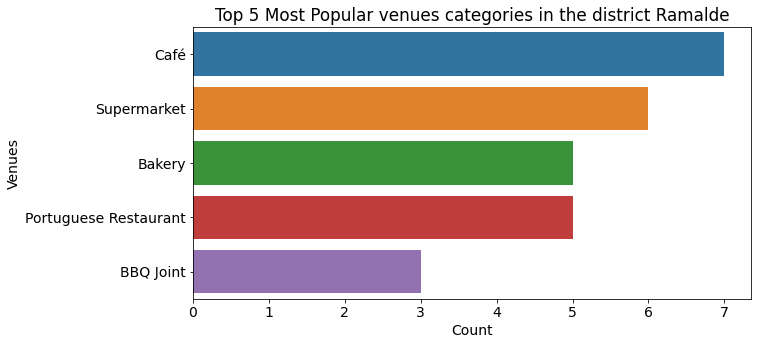

Number of Popular Sushi Venues is 1


In [68]:
ramalde, popular_venues_afn = popular_venues(porto_districts,'Ramalde')

In [69]:
ramalde

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004,22,0.014667,1,0.000667


In Ramalde, only one out of the 8 sushi restaurants is trendy. 

#### Paranhos

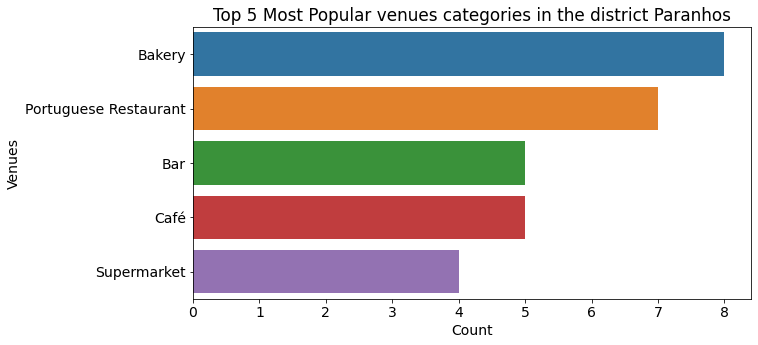

Number of Popular Sushi Venues is 1


In [70]:
paranhos, popular_venues_afn = popular_venues(porto_districts,'Paranhos')

In [71]:
paranhos

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.03125,10,0.00625


One out of 5 sushi restaurants are trendy in this district. 

## Clustering the districts

In [72]:
porto_districts.head()

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091,6,0.005455
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923,3,0.002308
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000,9,0.006000


In order to do the clustering one can only use the numerical attributes. In this case I'm gonna use the features which represent the density of the searched venues:
- Density of Sushi
- Density of Hotels
- Density of Schools&Universities
- Density of Transports

In [73]:
X = porto_districts.loc[:,['Density of Sushi','Density of Hotels','Density of Schools&Universities','Density of Transports']].values

In [74]:
X.shape

(7, 4)

Now let's normalize the dataset.

In [75]:
from sklearn.preprocessing import StandardScaler

clus_dataset = StandardScaler().fit_transform(X)

Now let's estimate the best k (number of clusters) using the elbow method.

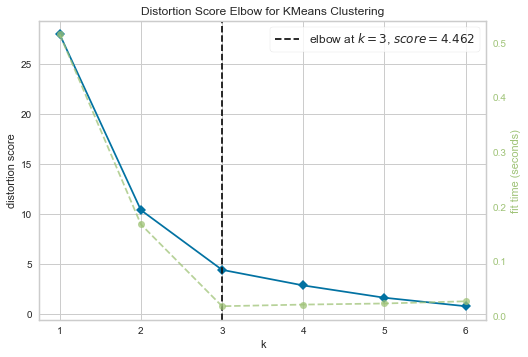

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
clus_model = KMeans()
visualizer = KElbowVisualizer(clus_model, k=(1,7))
visualizer.fit(clus_dataset)    #Fit the data to the visualizer
visualizer.show()   #Finalize and render the figure

Based on the elbow method I decided to use 3 seeds for clustering (k = 3)

In [77]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
k_means.fit(clus_dataset)

KMeans(n_clusters=3, n_init=12)

In [78]:
k_means_labels = k_means.labels_

In [79]:
set(k_means_labels)

{0, 1, 2}

In [80]:
porto_districts['Clusters']=k_means_labels

In [81]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports,Clusters
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091,6,0.005455,1
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615,2
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154,1
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923,3,0.002308,0
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000,9,0.006000,0
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667,1,0.000667,0
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250,10,0.006250,1


Colors of the clusters

In [82]:
colors = ['blue', 'red', 'green']

In [83]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports,Clusters
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,31,0.028182,21,0.019091,6,0.005455,1
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615,2
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154,1
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923,3,0.002308,0
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000,9,0.006000,0
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667,1,0.000667,0
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250,10,0.006250,1


Visualize the clusters

In [84]:
venues_map = folium.Map(location=[porto_districts['Latitude'].mean(), porto_districts['Longitude'].mean()], zoom_start=13) 

# add the clustered neighbourhoods
for lat, lng, district, cluster, density_sushi in zip(porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Districts'], porto_districts['Clusters'], porto_districts['Density of Sushi']):
    folium.CircleMarker(
        [lat, lng],
        radius=density_sushi*2000,
        color = colors[cluster],
        popup='Density of Sushi',
        fill = False,
        fill_color=colors[cluster],
        fill_opacity=0.6
    ).add_to(venues_map)
    
for lat, lng, district, cluster, density_hotels in zip(porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Districts'], porto_districts['Clusters'], porto_districts['Density of Hotels']):
    folium.CircleMarker(
        [lat, lng],
        radius=density_hotels*1500,
        color = colors[cluster],
        popup='Density of Hotels',
        fill = False,
        fill_color=colors[cluster],
        fill_opacity=0.2
    ).add_to(venues_map)
    
for lat, lng, district, cluster, density_schools in zip(porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Districts'], porto_districts['Clusters'], porto_districts['Density of Schools&Universities']):
    folium.CircleMarker(
        [lat, lng],
        radius=density_schools*1100,
        color = colors[cluster],
        popup='Density of Schools and Universities',
        fill = False,
        fill_color=colors[cluster],
        fill_opacity=0.2
    ).add_to(venues_map)

for lat, lng, district, cluster, density_transports in zip(porto_districts['Latitude'], porto_districts['Longitude'], porto_districts['Districts'], porto_districts['Clusters'], porto_districts['Density of Transports']):
    folium.CircleMarker(
        [lat, lng],
        radius=density_transports*1100,
        color = colors[cluster],
        popup='Density of Transports',
        fill = False,
        fill_color=colors[cluster],
        fill_opacity=0.2
    ).add_to(venues_map)
    
# display map
venues_map

Clearly the blue districts are the ones with a small amount of venues considered critical for this analysis. There is a significant difference between the number of venues of the green (city center) and red districts.

In [111]:
porto_districts

,Districts,Latitude,Longitude,Radius,# Sushi Restaurants,Density of Sushi,# Hotels,Density of Hotels,# Schools&Universities,Density of Schools&Universities,# Transports,Density of Transports,Clusters
0,Bonfim,41.152498,-8.588829,1100,1,0.000909,30,0.027273,21,0.019091,6,0.005455,0
1,Cedofeita/Ildefonso/Sé/Miragaia/Nicolau/Vitória,41.151764,-8.613740,1300,24,0.018462,50,0.038462,50,0.038462,19,0.014615,1
2,Lordelo/Massarelos,41.156975,-8.639555,1300,7,0.005385,32,0.024615,38,0.029231,8,0.006154,0
3,Campanhã,41.160127,-8.568764,1300,0,0.000000,2,0.001538,9,0.006923,3,0.002308,2
4,Aldoar/Foz/Nevogilde,41.161290,-8.667521,1500,9,0.006000,7,0.004667,24,0.016000,9,0.006000,2
5,Ramalde,41.177788,-8.638421,1500,8,0.005333,6,0.004000,22,0.014667,1,0.000667,2
6,Paranhos,41.174884,-8.607466,1600,5,0.003125,13,0.008125,50,0.031250,10,0.006250,0


Although the district of Bonfim (Red) has not so many critical venues comparing to the green district, it has only one Sushi Restaurant (comparing to the 24 of the green district). In addition, the top 3 most popular venues of Bonfim are restaurants and cafe's, which represent a tendency to food related establishments to perform well in the district of Bonfim. 

Lordelo/Massarelos and Paranhos are the other Red districts, but, comparing to Bonfim the densities of sushi restaurants are 6 and 3.4 times higher respectively. 